In [1]:
import pandas as pd
from gwpy.timeseries import TimeSeries
import pycbc
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import stats

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


We load the CSV that contains all glitch times from the first half of the third observing run.

In [2]:
glitches = pd.read_csv('./data/O3a_allifo.csv')
glitches.columns

Index(['GPStime', 'peakFreq', 'snr', 'amplitude', 'centralFreq', 'duration',
       'bandwidth', 'chisq', 'chisqDof', 'confidence', 'id', 'ifo', 'label',
       'imgUrl', 'Q-value'],
      dtype='object')

In [3]:
glitches.shape

(198455, 15)

As you can see it contains a bunch of columns. 
- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

Let's take a look at the **label** column to see all the different glitch classes.

In [ ]:
glitches['label'].unique()

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy',
       'Power_Line', 'Koi_Fish', 'Whistle',
       'Low_Frequency_Burst', 'Tomte', 'Repeating_Blips',
       'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above',
       'Low_Frequency_Lines', 'Wandering_Line', 'No_Glitch',
       'Air_Compressor', 'Chirp', 'Light_Modulation',
       'Paired_Doves', '1400Ripples', '1080Lines'], dtype=object)

As a dummy example let's select 'Tomte' glitches from LIGO Livingston (L1)

In [5]:
selected = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
len(selected), len(selected)

(20804, 20804)

In [6]:
np.round(np.mean(selected['duration'].values), 2)

np.float64(0.66)

You can see that 'Tomte' of 'L1' is a subset of the initial data set. How long are they?

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_133172/779566470.py:2: SyntaxWarning: invalid escape sequence '\m'
  label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')


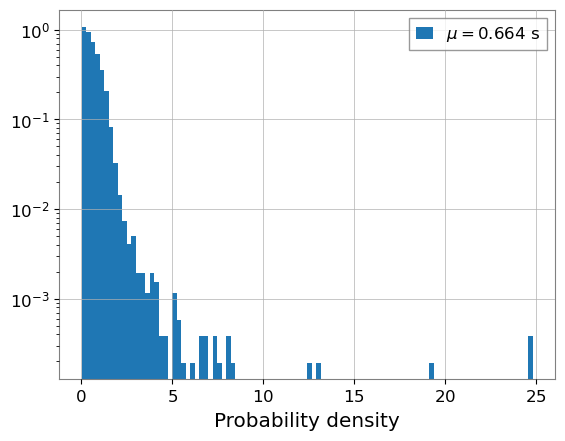

In [7]:
plt.hist(selected['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(selected['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.xlabel('Probability density')
plt.legend()

On average they are 0.664 s long, so we can visualize then in 2s. Let's pick a random example and visualize it.

In this code block

```python
noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
```

This fetches info from the LIGO OSC for L1 at the given gps time for 3 seconds at a sample rate of 4096 and is then converted to the pycbc format and whitened.

In [8]:
def get_noise_data(selected, srate=4096, tw=3, ifo='L1'):
    data_readings = []
    g_stars = selected['GPStime'].iloc[:150]
    # tw = 3 # time window per side. 
    # srate = 4096 # sampling rate
    # ifo = 'L1'

    for g_star in g_stars:
        noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
        noise = noise.to_pycbc()
        white_noise, psd = noise.whiten(len(noise) / (2 * srate),
                                        len(noise)/( 4 * srate),
                                        remove_corrupted = False,
                                        return_psd = True)
        # Crop 1s at each side to avoid border effects
        white_noise = white_noise[int(srate * 1):-int(srate * 1)]
        data = TimeSeries(white_noise, sample_rate = srate)
        q_scan = data.q_transform(qrange=[4,64], frange=[10, 2048],
                                tres=0.002, fres=0.5, whiten=False)
        t = data.times[int(srate * 1.5):-int(srate * 1.5)]
        y = data.value[int(srate * 1.5):-int(srate * 1.5)]
        data_readings.append((y,t))
        # noise_readings.append(white_noise)

    data_df = pd.DataFrame(data_readings, columns=['y', 't'])
    return data_df

In [9]:
data_df = get_noise_data(selected)

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


OK, now we can check its Gaussianity with Saphiro test. We test that the input time series (y) is Gaussian, against the alternative hypothesis that it is non-Gaussian. If the test yields a p-value below $\alpha=0.05$ it means that the input data is non-Gaussian

In [10]:
data_df['shapiro_pvalue'] = data_df['y'].apply(lambda y: stats.shapiro(y).pvalue)

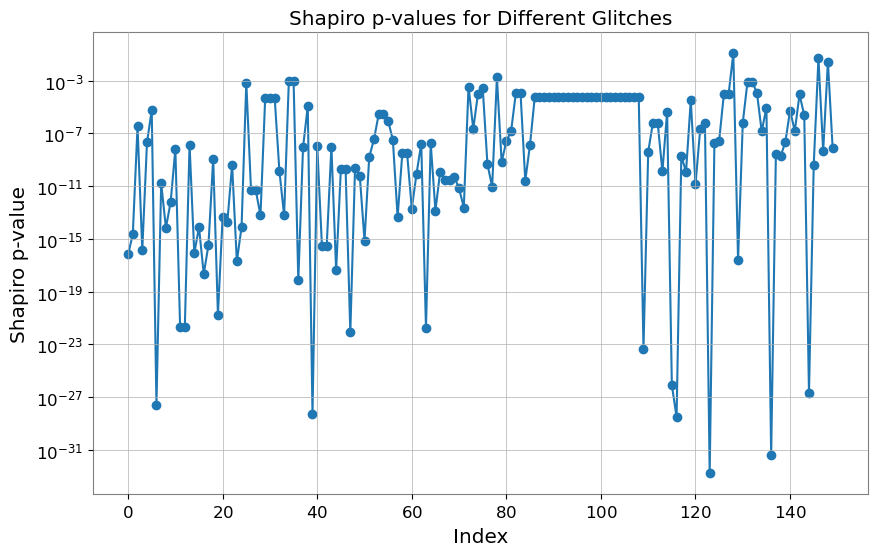

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(data_df['shapiro_pvalue'], marker='o', linestyle='-')
plt.xlabel('Index')
plt.yscale('log')
plt.ylabel('Shapiro p-value')
plt.title('Shapiro p-values for Different Glitches')
plt.grid(True)
plt.show()

In [12]:
print(f"Max Shapiro p-value: {data_df['shapiro_pvalue'].max()}")
print(f"Min Shapiro p-value: {data_df['shapiro_pvalue'].min()}")

Max Shapiro p-value: 0.11571115310990193
Min Shapiro p-value: 1.6900606781882096e-33


In [13]:
count = (data_df['shapiro_pvalue'] > 0.05).sum()
print(f"Number of Shapiro p-values above 0.05: {count}")

Number of Shapiro p-values above 0.05: 1
